In [1]:
import dill
#dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')

#https://stackoverflow.com/questions/34342155/how-to-pickle-or-store-jupyter-ipython-notebook-session-for-later
#https://www.reddit.com/r/IPython/comments/6reiqp/how_can_i_save_and_load_the_state_of_the_kernel/dl6f2yn/

In [2]:
import pandas as pd
import numpy as np

import warnings
import math
import datetime

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

import matplotlib as mt

import pickle

warnings.filterwarnings('ignore')

In [4]:
from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import RandomUnderSampler

In [5]:
%matplotlib notebook

In [6]:
i_clf_tree  = 1
i_clf_knn   = 2
i_clf_svm   = 3
i_clf_mlp   = 4
i_clf_naive = 5
i_clf_dummy = 6
nomes_algs = ['Tree', 'KNN', 'SVM', 'MLP', 'Naive', 'Dummy']

def ObterAlgoritmoClf(tp_algoritmo):
    if tp_algoritmo == i_clf_tree:
        return tree.DecisionTreeClassifier(criterion='gini', max_depth=5)
    elif tp_algoritmo == i_clf_knn:
        return KNeighborsClassifier(n_neighbors=3)
    elif tp_algoritmo == i_clf_svm:
        return svm.SVC(C=1.0, kernel='sigmoid')
    elif tp_algoritmo == i_clf_mlp:
        return MLPClassifier(hidden_layer_sizes=100, activation='relu')
    elif tp_algoritmo == i_clf_naive:
        return GaussianNB()
    elif tp_algoritmo == i_clf_dummy:
        return DummyClassifier(strategy='prior')
    else:
        return None

def ObterMatrizConfusao(clf, features_teste, target_teste):
    cls_predict = clf.predict(features_teste)
    mat_conf = confusion_matrix(target_teste, cls_predict)
    score = clf.score(features_teste, cls_predict)
    return mat_conf

def PrepararLista(lista):
    listaCopy = lista.copy()
    modelo = {  }
    for col in list(lista.columns.values):
        print(col)
        if (lista.dtypes[col] == 'object'):        
            col_le = LabelEncoder()

            col_labels = col_le.fit_transform(lista[col])
            col_mapping = {index: label for index, label in enumerate(col_le.classes_)}

            modelo[col] = col_mapping
            listaCopy[col] = col_labels
        else:
            modelo[col] =  'tipado'

    return modelo, listaCopy

def DM_Calcular(mod_matriz_confusao, ret):
    matriz_confusao = mod_matriz_confusao
        
    VP = matriz_confusao[0,0]
    FP = matriz_confusao[0,1]
    FN = matriz_confusao[1,0]
    VN = matriz_confusao[1,1]    
    
    sensibilidade  = VP/(VP+FN)*100
    especificidade = VN/(VN+FP)*100
    if np.isnan(sensibilidade):
        sensibilidade = 0
    if np.isnan(especificidade):
        especificidade = 0
        
    acuracia       = ((VP+VN)/(VP+VN+FP+FN))*100
    #fi             = (VP*VN - FP*FN) / Math.sqrt((VP + FP)*(VP + FN)*(VN + FP)*(VN + FN))
    VPP            = (VP/(VP+FP))*100
    VPN            = (VN/(VN+FN))*100
    eficiencia     = (sensibilidade+especificidade)/2
    totalP         = VP+FP
    totalN         = VN+FN
    totalVPFN      = VP+FN
    totalFPVN      = FP+VN
    totalG         = VP+FP+FN+VN

    if ret == 'sens':
        return round(sensibilidade, 2)
    elif ret == 'esp':
        return round(especificidade, 2)
    elif ret == 'acur':
        return round(acuracia, 2)
    elif ret == 'VPP':
        return round(VPP, 2)
    elif ret == 'VPN':
        return round(VPN, 2)
    elif ret == 'efic':
        return round(eficiencia, 2)
    elif ret == 'totP':
        return totalP
    elif ret == 'totN':
        return totalN
    elif ret == 'totG':
        return totalG
    else:
        return -1

In [7]:
colsExibir = ['id_alg', 'algoritmo', 'acur', 'sens', 'esp', 'efic', 'VPP', 'VPN', 'TExec' ]
metr_alg = ['sens', 'esp', 'acur', 'VPP', 'VPN', 'efic', 'totP', 'totN', 'totG' ]
cols = ['id_alg', 'algoritmo', 'acur', 'sens', 'esp', 'efic', 'VPP', 'VPN', 'mat_conf', 'AlgBin', 'TExec' ]
colsExibirMin = ['id_alg', 'algoritmo', 'acur', 'sens', 'esp', 'efic', 'TExec' ]

In [8]:
def ExibirMedidas(X_train, X_test, y_train, y_test):
    algs = []
    for idx in range(1, 7):
        dtIni = datetime.datetime.now()
        print(dtIni)
        
        d = dict(id_alg=idx, algoritmo=nomes_algs[idx - 1])
        print(d)

        clf = ObterAlgoritmoClf(idx)      
        # analisar o resultado depois retirar filtro
        #if idx != i_clf_tree:
        #    continue

        clf.fit(X_train, y_train)
        d['AlgBin'] = clf
        
        mat_conf = ObterMatrizConfusao(clf, X_test, y_test)
        for mtr in metr_alg:
            d[mtr] = DM_Calcular(mat_conf, mtr)
        d['mat_conf'] = mat_conf
        
        dtFim = datetime.datetime.now()
        dtDiff = dtFim - dtIni
        
        d['TExec'] = round(dtDiff.total_seconds() / 60, 2)
        
        print(clf)
        algs.append(d)        

    dfAlg = pd.DataFrame(algs)
    dfAlg = dfAlg.fillna(0)

    print(datetime.datetime.now())
  
    return dfAlg[cols]

def ReExibirMedidas(dfAlg2, X_test, y_test):
    lstdfAlg = dfAlg2.T.to_dict()
    algs = []
    print('ReExibirMedidas')
    for idx in range(1, 7):
        row = lstdfAlg[idx-1]
    
        print(row['algoritmo'])
        clf = row['AlgBin']
        dtIni = datetime.datetime.now()
        print(dtIni)
        
        mat_conf = ObterMatrizConfusao(clf, X_test, y_test)
        for mtr in metr_alg:
            row[mtr] = DM_Calcular(mat_conf, mtr)
        
        #d['Modelo'] = pickle.dumps(clf)

        print(clf)
        dtFim = datetime.datetime.now()
        dtDiff = dtFim - dtIni
        
        row['TExec'] = round(dtDiff.total_seconds() / 60, 2)
        
        algs.append(row)
    
    dfAlg = pd.DataFrame(algs)
    dfAlg = dfAlg.fillna(0)

    return dfAlg[cols]

In [9]:
def GerarResampling(tipo, X, y):
    if tipo == 'over':
        sm = SMOTE(random_state=42)
        return sm.fit_resample(X, y)
    elif tipo == 'under':
        #cnn = NeighbourhoodCleaningRule()
        cnn = RandomUnderSampler(random_state=42)
        return cnn.fit_resample(X, y)

In [10]:
def ExibirDesbanciamento(y):
    dfDesb = pd.DataFrame({'col': y})
    ig_verd = dfDesb['col'][ dfDesb['col'] == 1 ].size
    ig_fals = dfDesb['col'][ dfDesb['col'] == 0 ].size
    lstGrf = []
    dicv = dict()
    dicv['Atr'] = 'Certificado'
    dicv['Qtd'] = ig_verd
    lstGrf.append(dicv)
    dicf = dict()
    dicf['Atr'] = 'Não Certificado'
    dicf['Qtd'] = ig_fals
    lstGrf.append(dicf)

    if ig_verd > ig_fals:
        print(round(ig_fals / ig_verd, 2))
    else:
        print(round(ig_verd / ig_fals, 2))

    return pd.DataFrame(lstGrf)  

In [11]:
path_arq_dir = r'D:\Dados\bstoll\Documents\SuperOneNotes\jupyter-notebook\mooc-dataset'
path_arq =  path_arq_dir + '\\' + r'HMXPC13_DI_v2_5-14-14.csv'

df = pd.read_csv(path_arq)

In [12]:
df.head(5)

,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts,roles,incomplete_flag
0,HarvardX/CB22x/2013_Spring,MHxPC130442623,1,0,0,0,United States,NaN,NaN,NaN,0,2012-12-19,2013-11-17,NaN,9.0,NaN,NaN,0,NaN,1.0
1,HarvardX/CS50x/2012,MHxPC130442623,1,1,0,0,United States,NaN,NaN,NaN,0,2012-10-15,NaN,NaN,9.0,NaN,1.0,0,NaN,1.0
2,HarvardX/CB22x/2013_Spring,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,0,2013-02-08,2013-11-17,NaN,16.0,NaN,NaN,0,NaN,1.0
3,HarvardX/CS50x/2012,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,0,2012-09-17,NaN,NaN,16.0,NaN,NaN,0,NaN,1.0
4,HarvardX/ER22x/2013_Spring,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,0,2012-12-19,NaN,NaN,16.0,NaN,NaN,0,NaN,1.0


In [13]:
df.describe()

,registered,viewed,explored,certified,YoB,nevents,ndays_act,nplay_video,nchapters,nforum_posts,roles,incomplete_flag
count,641138.0,641138.000000,641138.000000,641138.000000,544533.000000,441987.000000,478395.000000,183608.000000,382385.000000,641138.000000,0.0,100161.0
mean,1.0,0.624299,0.061899,0.027587,1985.253279,431.008018,5.710254,114.844173,3.634423,0.018968,NaN,1.0
std,0.0,0.484304,0.240973,0.163786,8.891814,1516.116057,11.866471,426.996844,4.490987,0.229539,NaN,0.0
min,1.0,0.000000,0.000000,0.000000,1931.000000,1.000000,1.000000,1.000000,1.000000,0.000000,NaN,1.0
25%,1.0,0.000000,0.000000,0.000000,1982.000000,3.000000,1.000000,5.000000,1.000000,0.000000,NaN,1.0
50%,1.0,1.000000,0.000000,0.000000,1988.000000,24.000000,2.000000,18.000000,2.000000,0.000000,NaN,1.0
75%,1.0,1.000000,0.000000,0.000000,1991.000000,158.000000,4.000000,73.000000,4.000000,0.000000,NaN,1.0
max,1.0,1.000000,1.000000,1.000000,2013.000000,197757.000000,205.000000,98517.000000,48.000000,20.000000,NaN,1.0


In [14]:
df.dtypes

course_id             object
userid_DI             object
registered             int64
viewed                 int64
explored               int64
certified              int64
final_cc_cname_DI     object
LoE_DI                object
YoB                  float64
gender                object
grade                 object
start_time_DI         object
last_event_DI         object
nevents              float64
ndays_act            float64
nplay_video          float64
nchapters            float64
nforum_posts           int64
roles                float64
incomplete_flag      float64
dtype: object

In [15]:
classe = 'certified'
print(classe)

certified


In [16]:
#df['gender'] = df['gender'].fillna('')
#df['roles']  = df['roles'].fillna(0)
#df['YoB']    = df['YoB'].fillna(0)

In [17]:
df['Q_ndays_act']    = pd.qcut(df['ndays_act'],   4,duplicates='drop')
df['Q_nplay_video']  = pd.qcut(df['nplay_video'], 4,duplicates='drop')
df['Q_nchapters']    = pd.qcut(df['nchapters'],   4,duplicates='drop')
df['Q_nforum_posts'] = pd.qcut(df['nforum_posts'],4,duplicates='drop')

In [18]:
del df['nevents']
del df['ndays_act']
del df['nplay_video']
del df['nchapters']
del df['nforum_posts']

df = df.rename(columns=
          {'Q_nevents':      'nevents', 
           'Q_ndays_act':    'ndays_act',
           'Q_nplay_video':  'nplay_video',
           'Q_nchapters':    'nchapters',
           'Q_nforum_posts': 'nforum_posts',
          })

#start_time_DI
#last_event_DI
#del df['Unnamed']

In [19]:
df['start_year'] = pd.DatetimeIndex(df['start_time_DI']).year
df['start_month'] = pd.DatetimeIndex(df['start_time_DI']).month

df['last_e_year'] = pd.DatetimeIndex(df['last_event_DI']).year
df['last_e_month'] = pd.DatetimeIndex(df['last_event_DI']).month

In [20]:
del df['start_time_DI']
del df['last_event_DI']
del df['userid_DI']
#del df['Unnamed: 0']

In [21]:
# diminuir a eficiencia dos algoritmos
del df['nplay_video']
del df['nforum_posts']
del df['nchapters']
del df['ndays_act']
del df['incomplete_flag']
del df['grade']
del df['explored']
#del df['age']

In [22]:
for col in df.columns:
    if col == classe:
        next
    df[col] = df[col].fillna(0)
    print('======================================================================')
    print(col)
    print(df[col].unique())

course_id
['HarvardX/CB22x/2013_Spring' 'HarvardX/CS50x/2012'
 'HarvardX/ER22x/2013_Spring' 'HarvardX/PH207x/2012_Fall'
 'HarvardX/PH278x/2013_Spring' 'MITx/6.002x/2012_Fall'
 'MITx/6.002x/2013_Spring' 'MITx/14.73x/2013_Spring'
 'MITx/2.01x/2013_Spring' 'MITx/3.091x/2012_Fall'
 'MITx/3.091x/2013_Spring' 'MITx/6.00x/2012_Fall' 'MITx/6.00x/2013_Spring'
 'MITx/7.00x/2013_Spring' 'MITx/8.02x/2013_Spring'
 'MITx/8.MReV/2013_Summer']
registered
[1]
viewed
[0 1]
certified
[0 1]
final_cc_cname_DI
['United States' 'France' 'Unknown/Other' 'Mexico' 'Australia' 'India'
 'Canada' 'Russian Federation' 'Other South Asia'
 'Other North & Central Amer., Caribbean' 'Other Europe' 'Other Oceania'
 'Japan' 'Other Africa' 'Colombia' 'Germany'
 'Other Middle East/Central Asia' 'Poland' 'Indonesia' 'Other East Asia'
 'Bangladesh' 'China' 'United Kingdom' 'Ukraine' 'Spain' 'Greece'
 'Pakistan' 'Brazil' 'Nigeria' 'Egypt' 'Other South America' 'Portugal'
 'Philippines' 'Morocco']
LoE_DI
[0 'Secondary' "Bachelo

In [23]:
#======================================================================
#
# exibir dados agrupados para ver corelação do atributo com a classe
#
#======================================================================

for col in df.columns:
    if col == classe:
        next    
    
    dfTmpGrp = df.groupby([col, classe]).agg(['count'])
    print(dfTmpGrp)
    print('======================================================================')

                                      registered  viewed final_cc_cname_DI  \
                                           count   count             count   
course_id                   certified                                        
HarvardX/CB22x/2013_Spring  0              29618   29618             29618   
                            1                384     384               384   
HarvardX/CS50x/2012         0             168334  168334            168334   
                            1               1287    1287              1287   
HarvardX/ER22x/2013_Spring  0              55060   55060             55060   
                            1               2346    2346              2346   
HarvardX/PH207x/2012_Fall   0              39750   39750             39750   
                            1               1842    1842              1842   
HarvardX/PH278x/2013_Spring 0              38891   38891             38891   
                            1                711     711        

                     course_id  viewed final_cc_cname_DI  LoE_DI     YoB  \
                         count   count             count   count   count   
registered certified                                                       
1          0            623451  623451            623451  623451  623451   
           1             17687   17687             17687   17687   17687   

                      gender   roles start_year start_month last_e_year  \
                       count   count      count       count       count   
registered certified                                                      
1          0          623451  623451     623451      623451      623451   
           1           17687   17687      17687       17687       17687   

                     last_e_month  
                            count  
registered certified               
1          0               623451  
           1                17687  
                 course_id registered final_cc_cname_DI  LoE_DI

                              course_id registered  viewed final_cc_cname_DI  \
                                  count      count   count             count   
LoE_DI              certified                                                  
0                   0            102092     102092  102092            102092   
                    1              3916       3916    3916              3916   
Bachelor's          0            214898     214898  214898            214898   
                    1              4870       4870    4870              4870   
Doctorate           0             12965      12965   12965             12965   
                    1               422        422     422               422   
Less than Secondary 0             13690      13690   13690             13690   
                    1               402        402     402               402   
Master's            0            113971     113971  113971            113971   
                    1              4218 

                 course_id registered  viewed final_cc_cname_DI  LoE_DI  \
                     count      count   count             count   count   
gender certified                                                          
0      0             83199      83199   83199             83199   83199   
       1              3607       3607    3607              3607    3607   
f      0            138563     138563  138563            138563  138563   
       1              4232       4232    4232              4232    4232   
m      0            401672     401672  401672            401672  401672   
       1              9848       9848    9848              9848    9848   
o      0                17         17      17                17      17   

                     YoB   roles start_year start_month last_e_year  \
                   count   count      count       count       count   
gender certified                                                      
0      0           83199   83199    

                      course_id registered  viewed final_cc_cname_DI  LoE_DI  \
                          count      count   count             count   count   
last_e_year certified                                                          
0.0         0            178942     178942  178942            178942  178942   
            1                12         12      12                12      12   
2012.0      0            117866     117866  117866            117866  117866   
            1               347        347     347               347     347   
2013.0      0            326643     326643  326643            326643  326643   
            1             17328      17328   17328             17328   17328   

                          YoB  gender   roles start_year start_month  \
                        count   count   count      count       count   
last_e_year certified                                                  
0.0         0          178942  178942  178942     178942      1

In [24]:
df.describe()

,registered,viewed,certified,YoB,roles,start_year,start_month,last_e_year,last_e_month
count,641138.0,641138.000000,641138.000000,641138.000000,641138.0,641138.000000,641138.000000,641138.000000,641138.000000
mean,1.0,0.624299,0.027587,1686.120498,0.0,2012.530800,6.214055,1450.948437,4.243414
std,0.0,0.484304,0.163786,710.240700,0.0,0.499051,3.591690,902.850007,3.768378
min,1.0,0.000000,0.000000,0.000000,0.0,2012.000000,1.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,1975.000000,0.0,2012.000000,3.000000,0.000000,0.000000
50%,1.0,1.000000,0.000000,1986.000000,0.0,2013.000000,7.000000,2013.000000,3.000000
75%,1.0,1.000000,0.000000,1991.000000,0.0,2013.000000,9.000000,2013.000000,8.000000
max,1.0,1.000000,1.000000,2013.000000,0.0,2013.000000,12.000000,2013.000000,12.000000


In [25]:
data_dum = pd.get_dummies(df, drop_first=False)
#data_dum.head(10).to_csv('novoModelo.csv')

data_dum.shape

(641138, 69)

In [26]:
modelo, dfTrat = PrepararLista(data_dum)

registered
viewed
certified
YoB
roles
start_year
start_month
last_e_year
last_e_month
course_id_HarvardX/CB22x/2013_Spring
course_id_HarvardX/CS50x/2012
course_id_HarvardX/ER22x/2013_Spring
course_id_HarvardX/PH207x/2012_Fall
course_id_HarvardX/PH278x/2013_Spring
course_id_MITx/14.73x/2013_Spring
course_id_MITx/2.01x/2013_Spring
course_id_MITx/3.091x/2012_Fall
course_id_MITx/3.091x/2013_Spring
course_id_MITx/6.002x/2012_Fall
course_id_MITx/6.002x/2013_Spring
course_id_MITx/6.00x/2012_Fall
course_id_MITx/6.00x/2013_Spring
course_id_MITx/7.00x/2013_Spring
course_id_MITx/8.02x/2013_Spring
course_id_MITx/8.MReV/2013_Summer
final_cc_cname_DI_Australia
final_cc_cname_DI_Bangladesh
final_cc_cname_DI_Brazil
final_cc_cname_DI_Canada
final_cc_cname_DI_China
final_cc_cname_DI_Colombia
final_cc_cname_DI_Egypt
final_cc_cname_DI_France
final_cc_cname_DI_Germany
final_cc_cname_DI_Greece
final_cc_cname_DI_India
final_cc_cname_DI_Indonesia
final_cc_cname_DI_Japan
final_cc_cname_DI_Mexico
final_cc_cname

In [27]:
dfTrat.describe()

,registered,viewed,certified,YoB,roles,start_year,start_month,last_e_year,last_e_month,course_id_HarvardX/CB22x/2013_Spring,...,LoE_DI_0,LoE_DI_Bachelor's,LoE_DI_Doctorate,LoE_DI_Less than Secondary,LoE_DI_Master's,LoE_DI_Secondary,gender_0,gender_f,gender_m,gender_o
count,641138.0,641138.000000,641138.000000,641138.000000,641138.0,641138.000000,641138.000000,641138.000000,641138.000000,641138.000000,...,641138.000000,641138.000000,641138.000000,641138.000000,641138.000000,641138.000000,641138.000000,641138.000000,641138.000000,641138.000000
mean,1.0,0.624299,0.027587,1686.120498,0.0,2012.530800,6.214055,1450.948437,4.243414,0.046795,...,0.165343,0.342778,0.020880,0.021980,0.184343,0.264676,0.135394,0.222721,0.641859,0.000027
std,0.0,0.484304,0.163786,710.240700,0.0,0.499051,3.591690,902.850007,3.768378,0.211199,...,0.371491,0.474638,0.142983,0.146617,0.387764,0.441161,0.342144,0.416073,0.479454,0.005149
min,1.0,0.000000,0.000000,0.000000,0.0,2012.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,1975.000000,0.0,2012.000000,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,1.000000,0.000000,1986.000000,0.0,2013.000000,7.000000,2013.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.0,1.000000,0.000000,1991.000000,0.0,2013.000000,9.000000,2013.000000,8.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.0,1.000000,1.000000,2013.000000,0.0,2013.000000,12.000000,2013.000000,12.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
val_classes = dfTrat[classe].values
del dfTrat[classe]

0.03


<IPython.core.display.Javascript object>


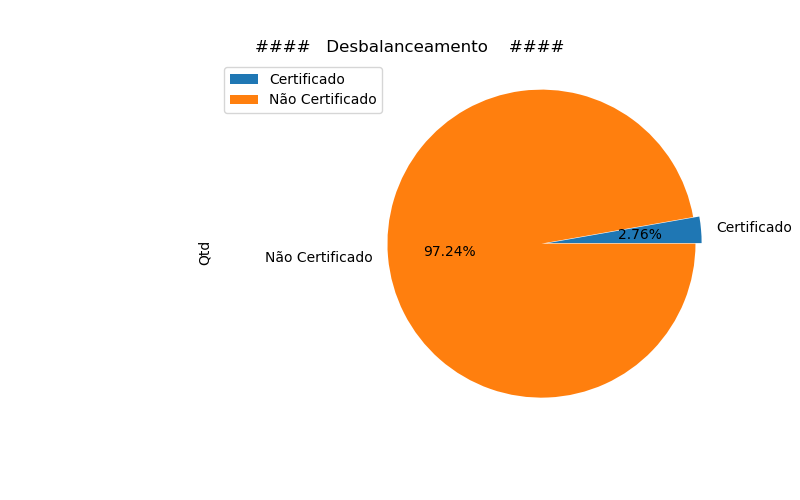

,Atr,Qtd
0,Certificado,17687
1,Não Certificado,623451


In [29]:
dfDesbOrig = ExibirDesbanciamento(val_classes)
dfDesbOrig.plot.pie(x='Atr', y='Qtd', title='####   Desbalanceamento    ####', labels=dfDesbOrig['Atr'].values, explode=(0.03, 0.01),autopct = '%1.2f%%', figsize=(8, 5))
dfDesbOrig

In [30]:
X_train, X_test, y_train, y_test = train_test_split(dfTrat, val_classes, test_size=0.3, random_state=42)
X_test_orig = X_test
y_test_orig = y_test

In [31]:
#======================================================================
#
#                          Obter pesos
#
#======================================================================

clf = ObterAlgoritmoClf(i_clf_tree)
clf.fit(X_train, y_train)

colunas = dfTrat.columns
for i in range(0, len(colunas)):
    print(colunas[i] + '  [ ' + str(round(clf.feature_importances_[i], 3)) + ' ]')

registered  [ 0.0 ]
viewed  [ 0.093 ]
YoB  [ 0.0 ]
roles  [ 0.0 ]
start_year  [ 0.163 ]
start_month  [ 0.228 ]
last_e_year  [ 0.108 ]
last_e_month  [ 0.217 ]
course_id_HarvardX/CB22x/2013_Spring  [ 0.0 ]
course_id_HarvardX/CS50x/2012  [ 0.124 ]
course_id_HarvardX/ER22x/2013_Spring  [ 0.012 ]
course_id_HarvardX/PH207x/2012_Fall  [ 0.0 ]
course_id_HarvardX/PH278x/2013_Spring  [ 0.0 ]
course_id_MITx/14.73x/2013_Spring  [ 0.04 ]
course_id_MITx/2.01x/2013_Spring  [ 0.0 ]
course_id_MITx/3.091x/2012_Fall  [ 0.0 ]
course_id_MITx/3.091x/2013_Spring  [ 0.0 ]
course_id_MITx/6.002x/2012_Fall  [ 0.012 ]
course_id_MITx/6.002x/2013_Spring  [ 0.0 ]
course_id_MITx/6.00x/2012_Fall  [ 0.0 ]
course_id_MITx/6.00x/2013_Spring  [ 0.0 ]
course_id_MITx/7.00x/2013_Spring  [ 0.0 ]
course_id_MITx/8.02x/2013_Spring  [ 0.0 ]
course_id_MITx/8.MReV/2013_Summer  [ 0.0 ]
final_cc_cname_DI_Australia  [ 0.0 ]
final_cc_cname_DI_Bangladesh  [ 0.0 ]
final_cc_cname_DI_Brazil  [ 0.0 ]
final_cc_cname_DI_Canada  [ 0.0 ]
final_c

In [32]:
dfAlg = ExibirMedidas(X_train, X_test, y_train, y_test)
dfAlg[colsExibir]

2019-04-17 15:39:20.079977
{'id_alg': 1, 'algoritmo': 'Tree'}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
2019-04-17 15:39:22.346298
{'id_alg': 2, 'algoritmo': 'KNN'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
2019-04-17 15:46:58.642884
{'id_alg': 3, 'algoritmo': 'SVM'}
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
2019-04-17 16:14:45.229892
{'id_alg': 4, 'algoritmo': 'MLP'}
M

,id_alg,algoritmo,acur,sens,esp,efic,VPP,VPN,TExec
0,1,Tree,97.20,97.20,0.00,48.60,100.00,0.00,0.04
1,2,KNN,96.81,97.97,40.37,69.17,98.76,29.03,7.60
2,3,SVM,97.20,97.20,0.00,48.60,100.00,0.00,27.78
3,4,MLP,97.20,97.20,0.00,48.60,100.00,0.00,9.97
4,5,Naive,65.73,99.40,6.66,53.03,65.14,86.30,0.04
5,6,Dummy,97.20,97.20,0.00,48.60,100.00,0.00,0.00


In [33]:
X_original = dfTrat.values
y_original = val_classes

In [34]:
#over_sampling
#https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html

print('over_sampling')
print(datetime.datetime.now())
X_over, y_over = GerarResampling('over', X_original, y_original)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=42)

print(datetime.datetime.now())

over_sampling
2019-04-17 17:07:07.183641
2019-04-17 17:07:17.443654


1.0


<IPython.core.display.Javascript object>


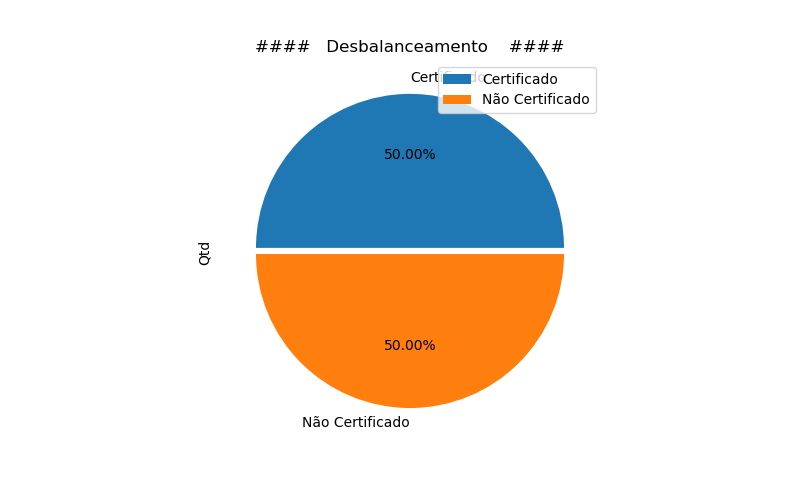

,Atr,Qtd
0,Certificado,623451
1,Não Certificado,623451


In [35]:
dfDesbOver = ExibirDesbanciamento(y_over)
dfDesbOver.plot.pie(x='Atr', y='Qtd', title='####   Desbalanceamento    ####', labels=dfDesbOver['Atr'].values, explode=(0.03, 0.01),autopct = '%1.2f%%', figsize=(8, 5))
dfDesbOver

In [36]:
dfAlgOver = ExibirMedidas(X_over, X_test, y_over, y_test)
dfAlgOver[colsExibir]

2019-04-17 17:07:52.324262
{'id_alg': 1, 'algoritmo': 'Tree'}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
2019-04-17 17:08:03.068270
{'id_alg': 2, 'algoritmo': 'KNN'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
2019-04-17 17:55:55.605951
{'id_alg': 3, 'algoritmo': 'SVM'}
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
2019-04-20 01:44:16.690193
{'id_alg': 4, 'algoritmo': 'MLP'}
M

,id_alg,algoritmo,acur,sens,esp,efic,VPP,VPN,TExec
0,1,Tree,89.51,89.47,89.54,89.51,89.57,89.44,0.18
1,2,KNN,96.78,96.56,97.00,96.78,97.02,96.54,47.88
2,3,SVM,49.96,0.00,49.96,24.98,0.00,100.00,3348.35
3,4,MLP,90.63,94.52,87.35,90.94,86.27,94.99,46.72
4,5,Naive,76.60,88.63,70.26,79.45,61.06,92.15,0.08
5,6,Dummy,50.04,50.04,0.00,25.02,100.00,0.00,0.01


In [37]:
#from imblearn.under_sampling import RandomUnderSampler
#randCnn = RandomUnderSampler(random_state=42)

In [38]:
#under_sampling
#https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.NeighbourhoodCleaningRule.html

print('under_sampling')
print(datetime.datetime.now())
X_under, y_under = GerarResampling('under', X_original, y_original) #original
#X_under, y_under = randCnn.fit_resample(X_original, y_original)
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42)
print(datetime.datetime.now())

under_sampling
2019-04-20 10:13:37.189287
2019-04-20 10:13:38.198081


1.0


<IPython.core.display.Javascript object>


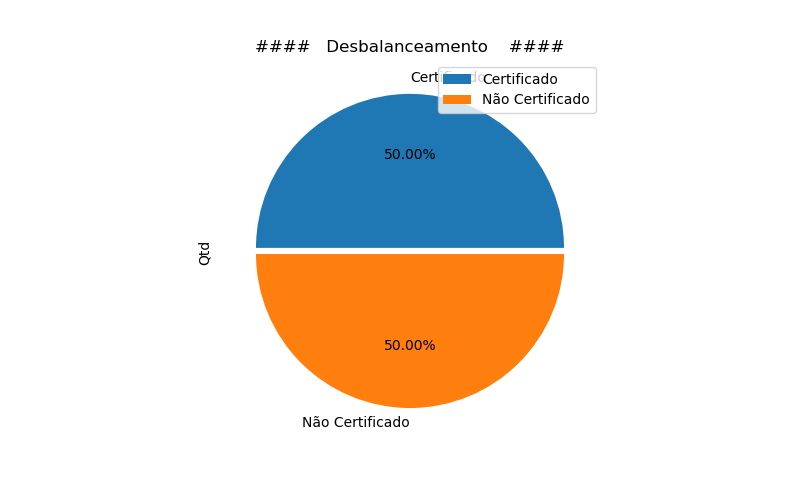

,Atr,Qtd
0,Certificado,17687
1,Não Certificado,17687


In [39]:
dfDesbUnder = ExibirDesbanciamento(y_under)
dfDesbUnder.plot.pie(x='Atr', y='Qtd', title='####   Desbalanceamento    ####', labels=dfDesbUnder['Atr'].values, explode=(0.03, 0.01),autopct = '%1.2f%%', figsize=(8, 5))
dfDesbUnder

In [40]:
dfAlgUnder = ExibirMedidas(X_under, X_test, y_under, y_test)
dfAlgUnder[colsExibir]

2019-04-20 10:13:46.305790
{'id_alg': 1, 'algoritmo': 'Tree'}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
2019-04-20 10:13:46.464221
{'id_alg': 2, 'algoritmo': 'KNN'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
2019-04-20 10:13:53.853508
{'id_alg': 3, 'algoritmo': 'SVM'}
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
2019-04-20 10:16:27.248606
{'id_alg': 4, 'algoritmo': 'MLP'}
M

,id_alg,algoritmo,acur,sens,esp,efic,VPP,VPN,TExec
0,1,Tree,88.53,88.65,88.42,88.53,88.37,88.70,0.00
1,2,KNN,93.69,94.17,93.22,93.69,93.14,94.24,0.12
2,3,SVM,50.03,0.00,50.03,25.02,0.00,100.00,2.56
3,4,MLP,65.84,99.53,59.45,79.49,31.79,99.85,0.07
4,5,Naive,75.94,87.88,69.74,78.81,60.15,91.71,0.00
5,6,Dummy,49.97,49.97,0.00,24.98,100.00,0.00,0.00


In [41]:
#metr_alg = ['sens', 'esp', 'acur', 'VPP', 'VPN', 'efic', 'totP', 'totN', 'totG' ]
#cols = ['id_alg', 'algoritmo', 'acur', 'sens', 'esp', 'efic', 'VPP', 'VPN', 'mat_conf', 'AlgBin', 'TExec']

dfAlgUnder2 = ReExibirMedidas(dfAlgUnder, X_test, y_test)
dfAlgUnder2[colsExibir]

ReExibirMedidas
Tree
2019-04-20 10:35:44.445198
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
KNN
2019-04-20 10:35:44.465225
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
SVM
2019-04-20 10:35:51.003182
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
MLP
2019-04-20 10:36:48.670322
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_

,id_alg,algoritmo,acur,sens,esp,efic,VPP,VPN,TExec
0,1,Tree,88.53,88.65,88.42,88.53,88.37,88.70,0.00
1,2,KNN,93.69,94.17,93.22,93.69,93.14,94.24,0.11
2,3,SVM,50.03,0.00,50.03,25.02,0.00,100.00,0.96
3,4,MLP,65.84,99.53,59.45,79.49,31.79,99.85,0.00
4,5,Naive,75.94,87.88,69.74,78.81,60.15,91.71,0.00
5,6,Dummy,49.97,49.97,0.00,24.98,100.00,0.00,0.00


In [42]:
dfAlgOver2 = ReExibirMedidas(dfAlgOver, X_test, y_test)
dfAlgOver2[colsExibir]

ReExibirMedidas
Tree
2019-04-20 11:50:24.623913
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
KNN
2019-04-20 11:50:24.644495
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
SVM
2019-04-20 11:50:47.275784
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
MLP
2019-04-20 12:25:42.203951
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_

,id_alg,algoritmo,acur,sens,esp,efic,VPP,VPN,TExec
0,1,Tree,88.02,87.68,88.37,88.03,88.46,87.59,0.00
1,2,KNN,93.19,90.46,96.31,93.38,96.55,89.83,0.38
2,3,SVM,50.03,0.00,50.03,25.02,0.00,100.00,34.92
3,4,MLP,89.88,93.14,87.08,90.11,86.08,93.67,0.00
4,5,Naive,74.72,83.47,69.61,76.54,61.61,87.82,0.00
5,6,Dummy,49.97,49.97,0.00,24.98,100.00,0.00,0.00


In [43]:
dfAlg

,id_alg,algoritmo,acur,sens,esp,efic,VPP,VPN,mat_conf,AlgBin,TExec
0,1,Tree,97.20,97.20,0.00,48.60,100.00,0.00,"[[186954, 0], [5388, 0]]","DecisionTreeClassifier(class_weight=None, crit...",0.04
1,2,KNN,96.81,97.97,40.37,69.17,98.76,29.03,"[[184644, 2310], [3824, 1564]]","KNeighborsClassifier(algorithm='auto', leaf_si...",7.60
2,3,SVM,97.20,97.20,0.00,48.60,100.00,0.00,"[[186954, 0], [5388, 0]]","SVC(C=1.0, cache_size=200, class_weight=None, ...",27.78
3,4,MLP,97.20,97.20,0.00,48.60,100.00,0.00,"[[186954, 0], [5388, 0]]","MLPClassifier(activation='relu', alpha=0.0001,...",9.97
4,5,Naive,65.73,99.40,6.66,53.03,65.14,86.30,"[[121780, 65174], [738, 4650]]","GaussianNB(priors=None, var_smoothing=1e-09)",0.04
5,6,Dummy,97.20,97.20,0.00,48.60,100.00,0.00,"[[186954, 0], [5388, 0]]","DummyClassifier(constant=None, random_state=No...",0.00


In [44]:
dfAlgUnder

,id_alg,algoritmo,acur,sens,esp,efic,VPP,VPN,mat_conf,AlgBin,TExec
0,1,Tree,88.53,88.65,88.42,88.53,88.37,88.70,"[[4686, 617], [600, 4710]]","DecisionTreeClassifier(class_weight=None, crit...",0.00
1,2,KNN,93.69,94.17,93.22,93.69,93.14,94.24,"[[4939, 364], [306, 5004]]","KNeighborsClassifier(algorithm='auto', leaf_si...",0.12
2,3,SVM,50.03,0.00,50.03,25.02,0.00,100.00,"[[0, 5303], [0, 5310]]","SVC(C=1.0, cache_size=200, class_weight=None, ...",2.56
3,4,MLP,65.84,99.53,59.45,79.49,31.79,99.85,"[[1686, 3617], [8, 5302]]","MLPClassifier(activation='relu', alpha=0.0001,...",0.07
4,5,Naive,75.94,87.88,69.74,78.81,60.15,91.71,"[[3190, 2113], [440, 4870]]","GaussianNB(priors=None, var_smoothing=1e-09)",0.00
5,6,Dummy,49.97,49.97,0.00,24.98,100.00,0.00,"[[5303, 0], [5310, 0]]","DummyClassifier(constant=None, random_state=No...",0.00


In [45]:
dfAlgOver

,id_alg,algoritmo,acur,sens,esp,efic,VPP,VPN,mat_conf,AlgBin,TExec
0,1,Tree,89.51,89.47,89.54,89.51,89.57,89.44,"[[167669, 19521], [19726, 167155]]","DecisionTreeClassifier(class_weight=None, crit...",0.18
1,2,KNN,96.78,96.56,97.00,96.78,97.02,96.54,"[[181607, 5583], [6463, 180418]]","KNeighborsClassifier(algorithm='auto', leaf_si...",47.88
2,3,SVM,49.96,0.00,49.96,24.98,0.00,100.00,"[[0, 187190], [0, 186881]]","SVC(C=1.0, cache_size=200, class_weight=None, ...",3348.35
3,4,MLP,90.63,94.52,87.35,90.94,86.27,94.99,"[[161493, 25697], [9363, 177518]]","MLPClassifier(activation='relu', alpha=0.0001,...",46.72
4,5,Naive,76.60,88.63,70.26,79.45,61.06,92.15,"[[114303, 72887], [14661, 172220]]","GaussianNB(priors=None, var_smoothing=1e-09)",0.08
5,6,Dummy,50.04,50.04,0.00,25.02,100.00,0.00,"[[187190, 0], [186881, 0]]","DummyClassifier(constant=None, random_state=No...",0.01


In [46]:
print('Original')
dfAlg[colsExibirMin]

Original


,id_alg,algoritmo,acur,sens,esp,efic,TExec
0,1,Tree,97.20,97.20,0.00,48.60,0.04
1,2,KNN,96.81,97.97,40.37,69.17,7.60
2,3,SVM,97.20,97.20,0.00,48.60,27.78
3,4,MLP,97.20,97.20,0.00,48.60,9.97
4,5,Naive,65.73,99.40,6.66,53.03,0.04
5,6,Dummy,97.20,97.20,0.00,48.60,0.00


In [47]:
print('Oversample')
dfAlgOver[colsExibirMin]

Oversample


,id_alg,algoritmo,acur,sens,esp,efic,TExec
0,1,Tree,89.51,89.47,89.54,89.51,0.18
1,2,KNN,96.78,96.56,97.00,96.78,47.88
2,3,SVM,49.96,0.00,49.96,24.98,3348.35
3,4,MLP,90.63,94.52,87.35,90.94,46.72
4,5,Naive,76.60,88.63,70.26,79.45,0.08
5,6,Dummy,50.04,50.04,0.00,25.02,0.01


In [48]:
print('Oversample - Teste com dados originais')
dfAlgOver2[colsExibirMin]

Oversample - Teste com dados originais


,id_alg,algoritmo,acur,sens,esp,efic,TExec
0,1,Tree,88.02,87.68,88.37,88.03,0.00
1,2,KNN,93.19,90.46,96.31,93.38,0.38
2,3,SVM,50.03,0.00,50.03,25.02,34.92
3,4,MLP,89.88,93.14,87.08,90.11,0.00
4,5,Naive,74.72,83.47,69.61,76.54,0.00
5,6,Dummy,49.97,49.97,0.00,24.98,0.00


In [49]:
print('Undersample')
dfAlgUnder[colsExibirMin]

Undersample


,id_alg,algoritmo,acur,sens,esp,efic,TExec
0,1,Tree,88.53,88.65,88.42,88.53,0.00
1,2,KNN,93.69,94.17,93.22,93.69,0.12
2,3,SVM,50.03,0.00,50.03,25.02,2.56
3,4,MLP,65.84,99.53,59.45,79.49,0.07
4,5,Naive,75.94,87.88,69.74,78.81,0.00
5,6,Dummy,49.97,49.97,0.00,24.98,0.00


In [50]:
print('Undersample - Teste com dados originais')
dfAlgUnder2[colsExibirMin]

Undersample - Teste com dados originais


,id_alg,algoritmo,acur,sens,esp,efic,TExec
0,1,Tree,88.53,88.65,88.42,88.53,0.00
1,2,KNN,93.69,94.17,93.22,93.69,0.11
2,3,SVM,50.03,0.00,50.03,25.02,0.96
3,4,MLP,65.84,99.53,59.45,79.49,0.00
4,5,Naive,75.94,87.88,69.74,78.81,0.00
5,6,Dummy,49.97,49.97,0.00,24.98,0.00


In [51]:
dfAlgUnder2.T.to_dict()[0]['algoritmo']

'Tree'

In [52]:
dill.dump_session('notebook_env.db')

In [53]:
dfTrat.shape

(641138, 68)